We are starting from `fastq` files as raw data: 

In [76]:
list.files('fastq')

[1] "01_IN_23_NT_S3_L002_R1_001.fastq.gz"         
 [2] "01_IN_23_NT_S3_L002_trim.fastq.gz"           
 [3] "02_IN_23_METTL3_S4_L002_R1_001.fastq.gz"     
 [4] "02_IN_23_METTL3_S4_L002_trim.fastq.gz"       
 [5] "03_IN_23_METTL14_S5_L002_R1_001.fastq.gz"    
 [6] "03_IN_23_METTL14_S5_L002_trim.fastq.gz"      
 [7] "04_IN_23_Virma_S6_L002_R1_001.fastq.gz"      
 [8] "04_IN_23_Virma_S6_L002_trim.fastq.gz"        
 [9] "05_IN_23_WTAP_S7_L002_R1_001.fastq.gz"       
[10] "05_IN_23_WTAP_S7_L002_trim.fastq.gz"         
[11] "06_IN_24_NT_S8_L002_R1_001.fastq.gz"         
[12] "06_IN_24_NT_S8_L002_trim.fastq.gz"           
[13] "07_IN_24_METTL3_S9_L002_R1_001.fastq.gz"     
[14] "07_IN_24_METTL3_S9_L002_trim.fastq.gz"       
[15] "08_IN_24_METTL14_S10_L002_R1_001.fastq.gz"   
[16] "08_IN_24_METTL14_S10_L002_trim.fastq.gz"     
[17] "09_IN_24_Virma_S11_L002_R1_001.fastq.gz"     
[18] "09_IN_24_Virma_S11_L002_trim.fastq.gz"       
[19] "10_IN_24_WTAP_S12_L002_R1_001.fastq.gz"      
[20] "10_IN_24_WTAP_S12_L002_trim.fastq.gz"        
[21] "11_meRIP_23_NT_S13_L002_R1_001.fastq.gz"     
[22] "11_meRIP_23_NT_S13_L002_trim.fastq.gz"       
[23] "12_meRIP_23_METTL3_S14_L002_R1_001.fastq.gz" 
[24] "12_meRIP_23_METTL3_S14_L002_trim.fastq.gz"   
[25] "13_meRIP_23_METTL14_S15_L002_R1_001.fastq.gz"
[26] "13_meRIP_23_METTL14_S15_L002_trim.fastq.gz"  
[27] "14_meRIP_23_Virma_S16_L002_R1_001.fastq.gz"  
[28] "14_meRIP_23_Virma_S16_L002_trim.fastq.gz"    
[29] "15_meRIP_23_WTAP_S17_L002_R1_001.fastq.gz"   
[30] "15_meRIP_23_WTAP_S17_L002_trim.fastq.gz"     
[31] "16_meRIP_24_NT_S18_L002_R1_001.fastq.gz"     
[32] "16_meRIP_24_NT_S18_L002_trim.fastq.gz"       
[33] "17_meRIP_24_METTL3_S19_L002_R1_001.fastq.gz" 
[34] "17_meRIP_24_METTL3_S19_L002_trim.fastq.gz"   
[35] "18_meRIP_24_METTL14_S20_L002_R1_001.fastq.gz"
[36] "18_meRIP_24_METTL14_S20_L002_trim.fastq.gz"  
[37] "19_meRIP_24_Virma_S21_L002_R1_001.fastq.gz"  
[38] "19_meRIP_24_Virma_S21_L002_trim.fastq.gz"    
[39] "20_meRIP_24_WTAP_S22_L002_R1_001.fastq.gz"   
[40] "20_meRIP_24_WTAP_S22_L002_trim.fastq.gz"

## Trimming 

In [ ]:
%%bash 
cd ~/People/Judd/fastq
for f in *_L002_R1_001.fastq.gz; do  
    out=${f/\_S[1-9]*/.trim.fastq.gz}; 
    cutadapt -j 12 -q 15 -m 20 -a NNNAGATCGGAAGAGCACACGTCTGAACTCCAGTCA -o ../trim/$out $f; 
done

## Alignment

Unmmaped reads for each `fastq` file saved for later alignment to HIV genome 

Human genome: `gencode.v28.annotation.gtf`

In [ ]:
%%bash 
STAR --genomeLoad LoadAndExit --genomeDir /rumi/shams/abe/genomes/hg38/
for f in trim/*.fastq.gz;do
    out=${f/.trim.fastq.gz/_};
    out=${out/trim/bam};
    STAR --outSAMtype BAM SortedByCoordinate --readFilesCommand zcat --runThreadN 16 --genomeDir /rumi/shams/abe/genomes/hg38/ --readFilesIn $f --outFileNamePrefix $out --outReadsUnmapped Fastx;
done
STAR --genomeLoad Remove --genomeDir /rumi/shams/abe/genomes/hg38/

HIV genome indices created by changing sequence provided by Judd to `.fa` format

In [ ]:
%%bash 
# make hiv genome indices 
bowtie2-build HIV/HIV.fa HIV/HIV
# Aligning to hiv genome 
for f in fastq_unmapped/*; do
	o=${f/.fastq/.bam};
 	o=${o/fastq_unmapped/bam};
 	bowtie2 --sensitive -N 1 -x HIV/HIV -U $f | samtools sort -o $o;
done

All `bam`  files (mapped to human genome or hiv genome) renamed in this format: 
> `<sample>.<species>.<treatment>.<input/m6A>.bam`

## Peakcalling 

We are using RADAR package for meRIP data analysis ([see RADAR manual](https://scottzijiezhang.github.io/RADARmanual/workflow.html)). It will run over bam files for each enzyme treatment. `run_radar` function do it all for you :) 

In [3]:
library("RADAR")
run_radar <- function(enz, gtf,species='human', cutoff = 0.1, Beta_cutoff = 0.5,threads = 18){
    outputDir = paste("radar", species,enz, sep='/')
    radar <- countReads(
        samplenames = unlist(lapply (c('s23','s24'), paste, paste(species,c('NT',enz), sep='.'),sep='.')),
        gtf = gtf,
        bamFolder = "bam",
        modification = 'm6A',
        strandToKeep = "opposite",
        outputDir = outputDir,
        threads = threads,
        saveOutput = TRUE
    )
    saveRDS(radar, file = paste(outputDir,"raw.radar.rds",sep='/')) # ,compress = TRUE)
    radar <- normalizeLibrary(radar, boxPlot = FALSE)
    radar <- adjustExprLevel(radar)
    
    variable(radar) <- data.frame( Group =data.frame( Group = rep(c("Ctrl","Treated"),2)) )
    radar <- filterBins(radar,minCountsCutOff = 15)
    radar <- diffIP_parallel(radar, thread = threads)
    top_bins <- extractIP(radar,filtered = T)[order(rowMeans( extractIP(radar,filtered = T) ),decreasing = T)[1:1000],]
    radar <- reportResult(radar, cutoff = cutoff, Beta_cutoff = Beta_cutoff, threads=threads)
    result <- results(radar)
    
    write.csv(results, paste(outputDir,'radar.bed',sep='/'), quote = FALSE, row.names = FALSE)
    saveRDS(radar, file = paste(outputDir,"radar.rds",sep='/')) # ,compress = TRUE)
}


### Run radar on human bam files 

In [11]:
gtf = "/rumi/shams/genomes/hg38/gencode.v28.annotation.gtf"

Reading gtf file to obtain gene model
Filter out ambiguous model...


Import genomic features from the file as a GRanges object ... OK
Prepare the 'metadata' data frame ... OK
Make the TxDb object ... Warning message in .get_cds_IDX(mcols0$type, mcols0$phase):
“The "phase" metadata column contains non-NA values for features of type
  stop_codon. This information was ignored.”OK


Gene model obtained from gtf file...
counting reads for each genes, this step may takes a few hours....
Hyper-thread registered: TRUE 
Using 18 thread(s) to count reads in continuous bins...
Time used to count reads: 24.1178261041641 mins... 


Warning message in bplt(at[i], wid = width[i], stats = z$stats[, i], out = z$out[z$group == :
“Outlier (Inf) in boxplot 3 is not drawn”

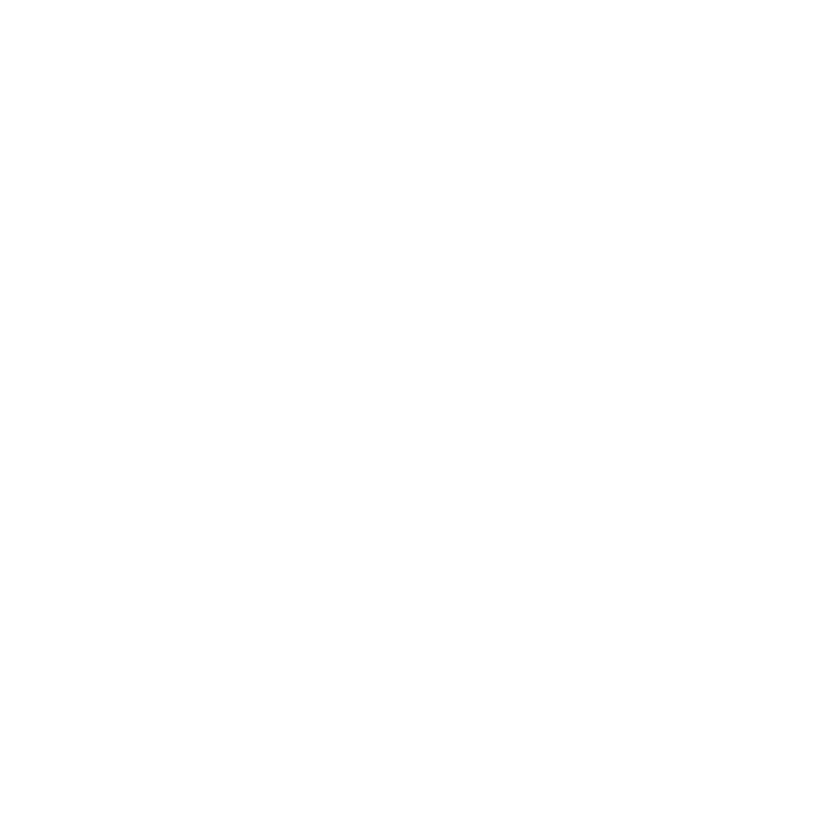

Adjusting expression level using Input geneSum read count...
Filtering bins with low read counts...
Bins with average counts lower than  15  in both groups have been removed...
Filtering bins that is enriched in IP experiment...The predictor variable has been converted:
    Ctl Treated     Ctl Treated 
      0       1       0       1 
running PoissonGamma test at single beta mode
Hyper-thread registered: TRUE 
Using 18 thread(s) to run PoissonGamma test...
Time used to run PoissonGamma test: 0.74136548837026 mins... 

Returning normalized IP read counts.
Returning normalized IP read counts.
Hyper-thread registered: TRUE 
Using 18 thread(s) to report merged report...
Time used to report peaks: 1.29077123006185 mins... 
When merging neighboring significant bins, logFC was reported as the max logFC among these bins.
p-value of these bins were combined by Fisher's method.
There are 5750 reported differential loci at FDR < 0.1 and logFoldChange > 0.5.


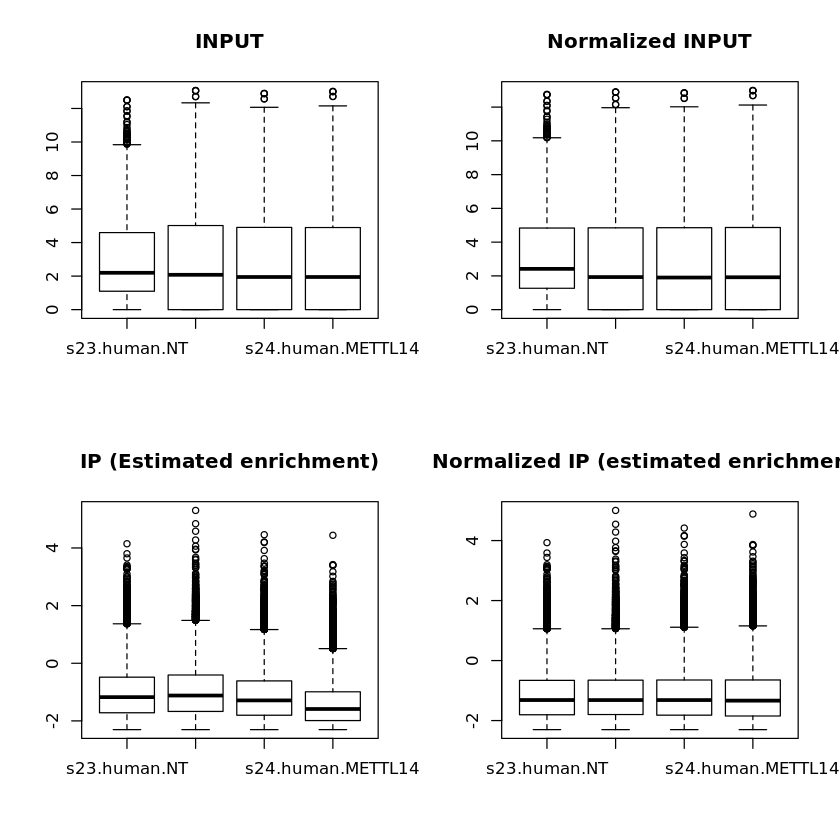

In [12]:
enz = 'METTL14'
run_radar(enz,gtf)

In [14]:
enz = 'METTL3'
run_radar(enz,gtf)

Reading gtf file to obtain gene model
Filter out ambiguous model...


Import genomic features from the file as a GRanges object ... OK
Prepare the 'metadata' data frame ... OK
Make the TxDb object ... Warning message in .get_cds_IDX(mcols0$type, mcols0$phase):
“The "phase" metadata column contains non-NA values for features of type
  stop_codon. This information was ignored.”OK


[1] "Stage: index bam file bam/s23.human.Virma.input.bam"
[1] "Stage: index bam file bam/s23.human.Virma.m6A.bam"
[1] "Stage: index bam file bam/s24.human.Virma.input.bam"
[1] "Stage: index bam file bam/s24.human.Virma.m6A.bam"
Reading gtf file to obtain gene model
Filter out ambiguous model...


Import genomic features from the file as a GRanges object ... OK
Prepare the 'metadata' data frame ... OK
Make the TxDb object ... Warning message in .get_cds_IDX(mcols0$type, mcols0$phase):
“The "phase" metadata column contains non-NA values for features of type
  stop_codon. This information was ignored.”OK


Gene model obtained from gtf file...
counting reads for each genes, this step may takes a few hours....
Hyper-thread registered: TRUE 
Using 18 thread(s) to count reads in continuous bins...
Time used to count reads: 26.6394029458364 mins... 


Warning message in bplt(at[i], wid = width[i], stats = z$stats[, i], out = z$out[z$group == :
“Outlier (Inf) in boxplot 3 is not drawn”Warning message in bplt(at[i], wid = width[i], stats = z$stats[, i], out = z$out[z$group == :
“Outlier (Inf) in boxplot 4 is not drawn”

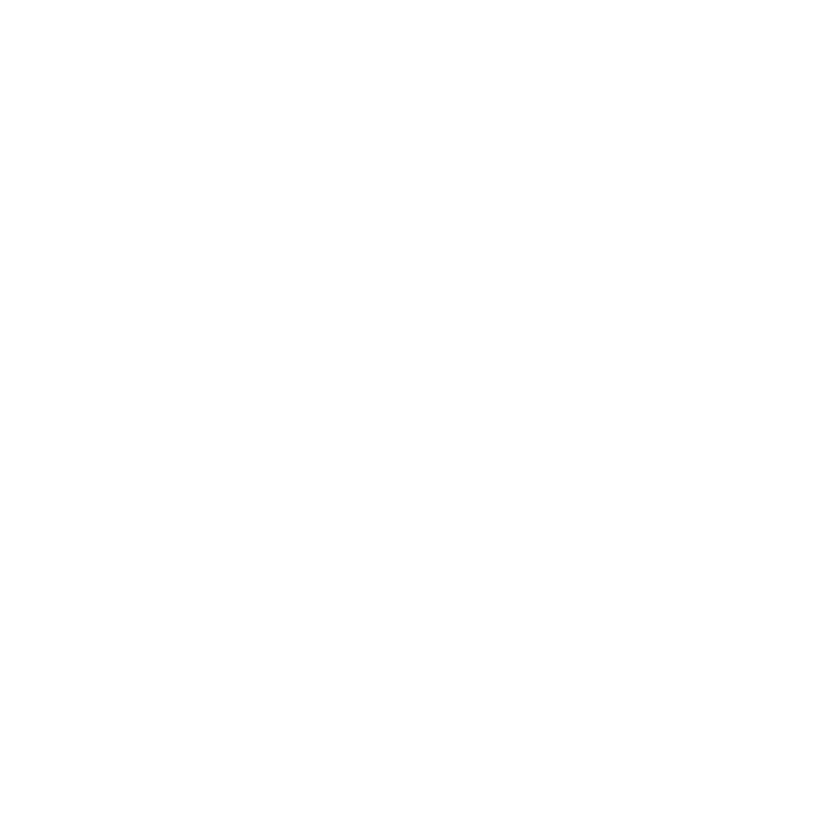

Adjusting expression level using Input geneSum read count...
Filtering bins with low read counts...
Bins with average counts lower than  15  in both groups have been removed...
Filtering bins that is enriched in IP experiment...The predictor variable has been converted:
input meRIP input meRIP 
    0     1     0     1 
running PoissonGamma test at single beta mode
Hyper-thread registered: TRUE 
Using 18 thread(s) to run PoissonGamma test...
Time used to run PoissonGamma test: 0.795921897888184 mins... 

Returning normalized IP read counts.
Returning normalized IP read counts.
Hyper-thread registered: TRUE 
Using 18 thread(s) to report merged report...
Time used to report peaks: 0.981886716683706 mins... 
When merging neighboring significant bins, logFC was reported as the max logFC among these bins.
p-value of these bins were combined by Fisher's method.
There are 5488 reported differential loci at FDR < 0.1 and logFoldChange > 0.5.


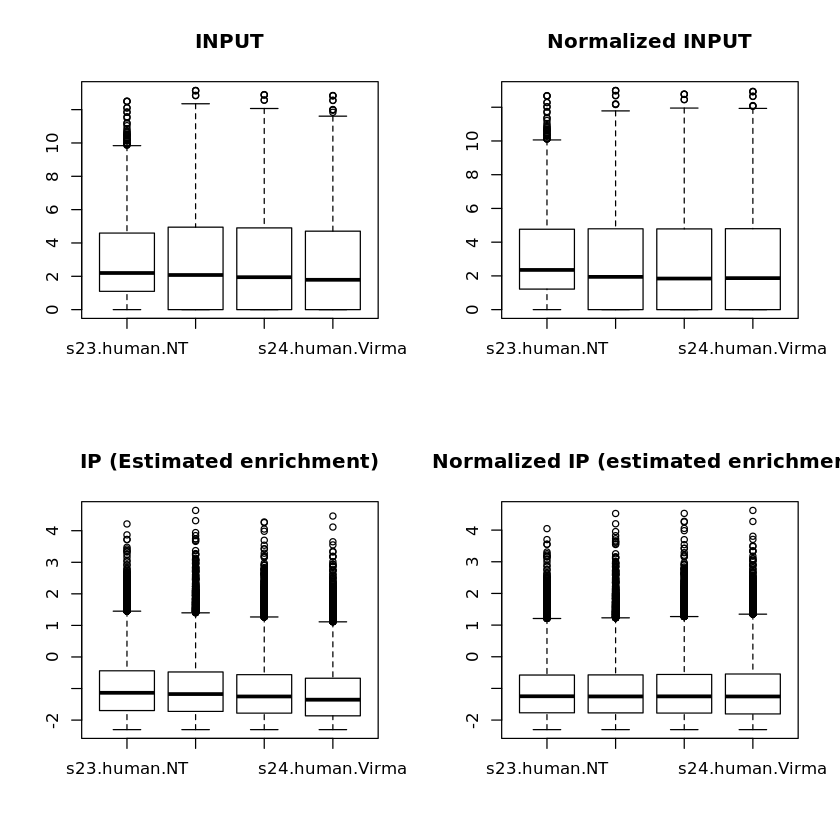

In [60]:
enz = 'Virma'
run_radar(enz,gtf)

[1] "Stage: index bam file bam/s23.human.WTAP.input.bam"
[1] "Stage: index bam file bam/s23.human.WTAP.m6A.bam"
[1] "Stage: index bam file bam/s24.human.WTAP.input.bam"
[1] "Stage: index bam file bam/s24.human.WTAP.m6A.bam"
Reading gtf file to obtain gene model
Filter out ambiguous model...


Import genomic features from the file as a GRanges object ... OK
Prepare the 'metadata' data frame ... OK
Make the TxDb object ... Warning message in .get_cds_IDX(mcols0$type, mcols0$phase):
“The "phase" metadata column contains non-NA values for features of type
  stop_codon. This information was ignored.”OK


Gene model obtained from gtf file...
counting reads for each genes, this step may takes a few hours....
Hyper-thread registered: TRUE 
Using 18 thread(s) to count reads in continuous bins...
Time used to count reads: 29.0011871933937 mins... 


Warning message in bplt(at[i], wid = width[i], stats = z$stats[, i], out = z$out[z$group == :
“Outlier (Inf) in boxplot 1 is not drawn”Warning message in bplt(at[i], wid = width[i], stats = z$stats[, i], out = z$out[z$group == :
“Outlier (Inf) in boxplot 3 is not drawn”Warning message in bplt(at[i], wid = width[i], stats = z$stats[, i], out = z$out[z$group == :
“Outlier (Inf) in boxplot 4 is not drawn”

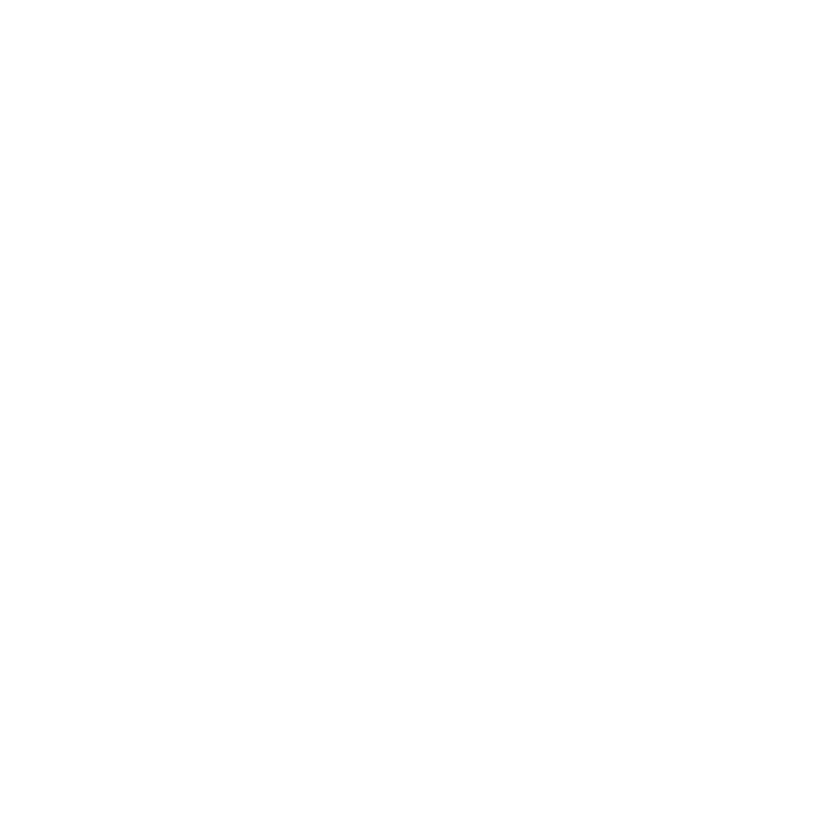

Adjusting expression level using Input geneSum read count...
Filtering bins with low read counts...
Bins with average counts lower than  15  in both groups have been removed...
Filtering bins that is enriched in IP experiment...The predictor variable has been converted:
input meRIP input meRIP 
    0     1     0     1 
running PoissonGamma test at single beta mode
Hyper-thread registered: TRUE 
Using 18 thread(s) to run PoissonGamma test...
Time used to run PoissonGamma test: 0.771063359578451 mins... 

Returning normalized IP read counts.
Returning normalized IP read counts.
Hyper-thread registered: TRUE 
Using 18 thread(s) to report merged report...
Time used to report peaks: 1.17677079439163 mins... 
When merging neighboring significant bins, logFC was reported as the max logFC among these bins.
p-value of these bins were combined by Fisher's method.
There are 6961 reported differential loci at FDR < 0.1 and logFoldChange > 0.5.


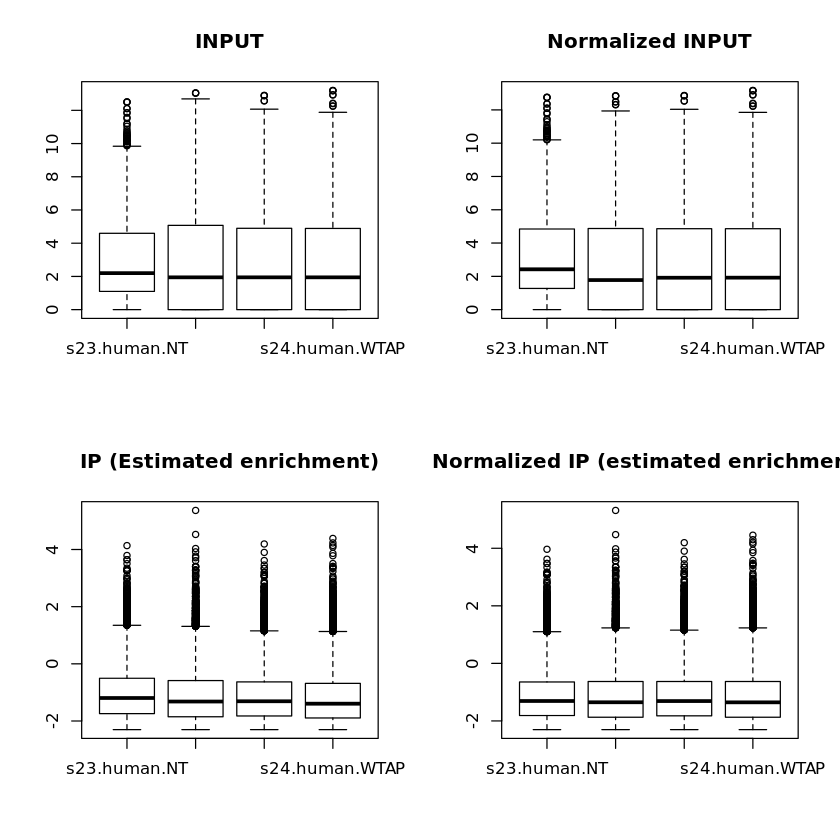

In [61]:
enz = 'WTAP'
run_radar(enz,gtf)

In [ ]:
# cat radar.bed | awk -F, '{OFS=",";print $1,$2,$3,$4,"1",$6}' > radar.c.bed
# awk '{gsub(/\,/,"\t");print;}' radar.bed > radar.t.bed

# Plot heatmaps 
Using `plotHeatMap` function from RADAR package:

### METTL14

In [77]:
radar = readRDS('radar/human/METTL14/radar.rds')

Plot heat map for differential loci at FDR < 0.1 and logFoldChange > 0.5.
Returning normalized and expression level adjusted IP read counts.


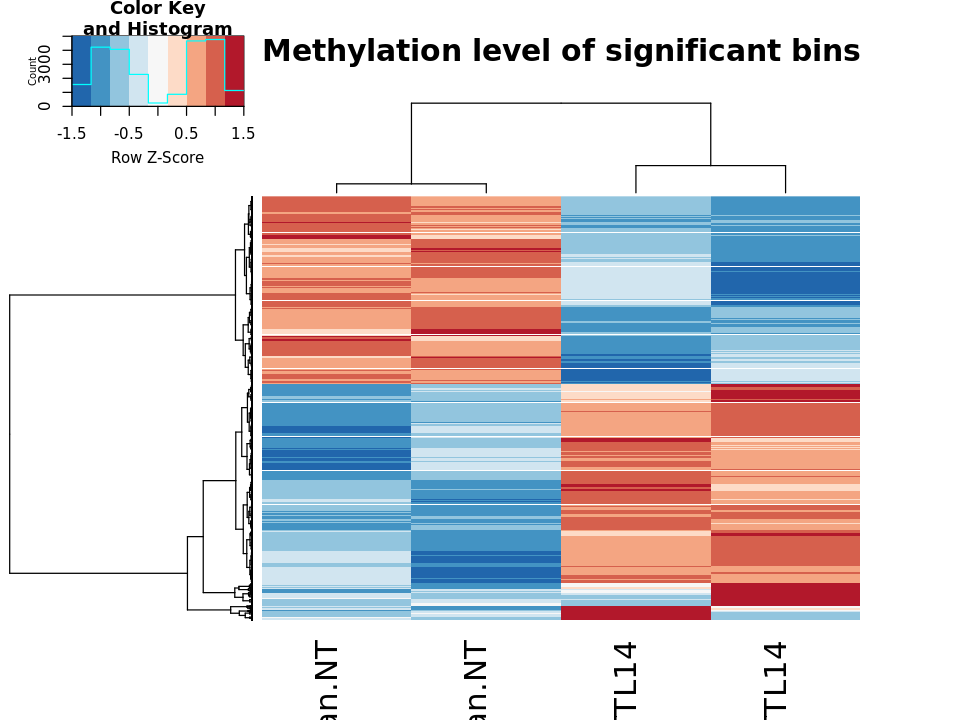

In [93]:
options(repr.plot.width=8, repr.plot.height=6)
plotHeatMap(radar)
# plotHeatMap(radar,covariates = FALSE)

There are 5750 reported differential loci at FDR < 0.1 and logFoldChange > 0.5.


Import genomic features from the file as a GRanges object ... OK
Prepare the 'metadata' data frame ... OK
Make the TxDb object ... Warning message in .get_cds_IDX(mcols0$type, mcols0$phase):
“The "phase" metadata column contains non-NA values for features of type
  stop_codon. This information was ignored.”OK


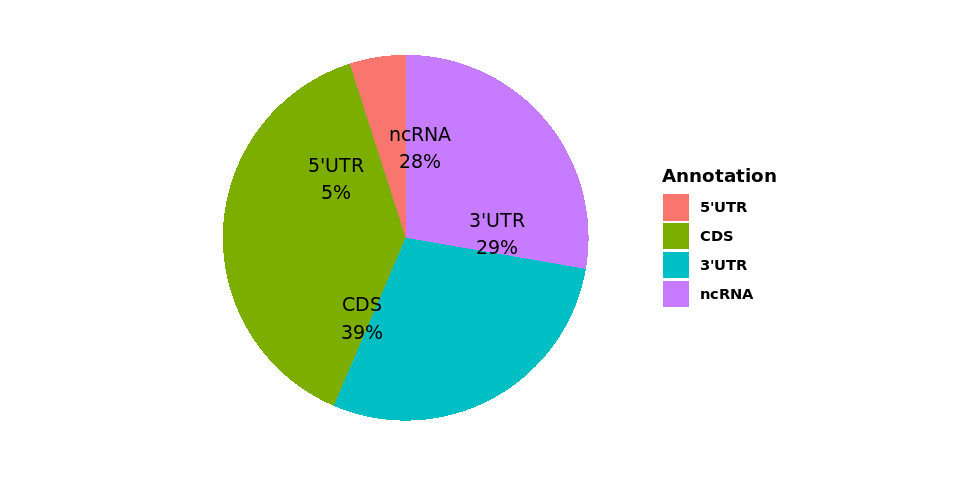

In [91]:
options(repr.plot.width=8, repr.plot.height=4)
peakDistribution(radar)

### METTL3

In [94]:
radar = readRDS('radar/human/METTL3/radar.rds')

Plot heat map for differential loci at FDR < 0.1 and logFoldChange > 0.5.
Returning normalized and expression level adjusted IP read counts.


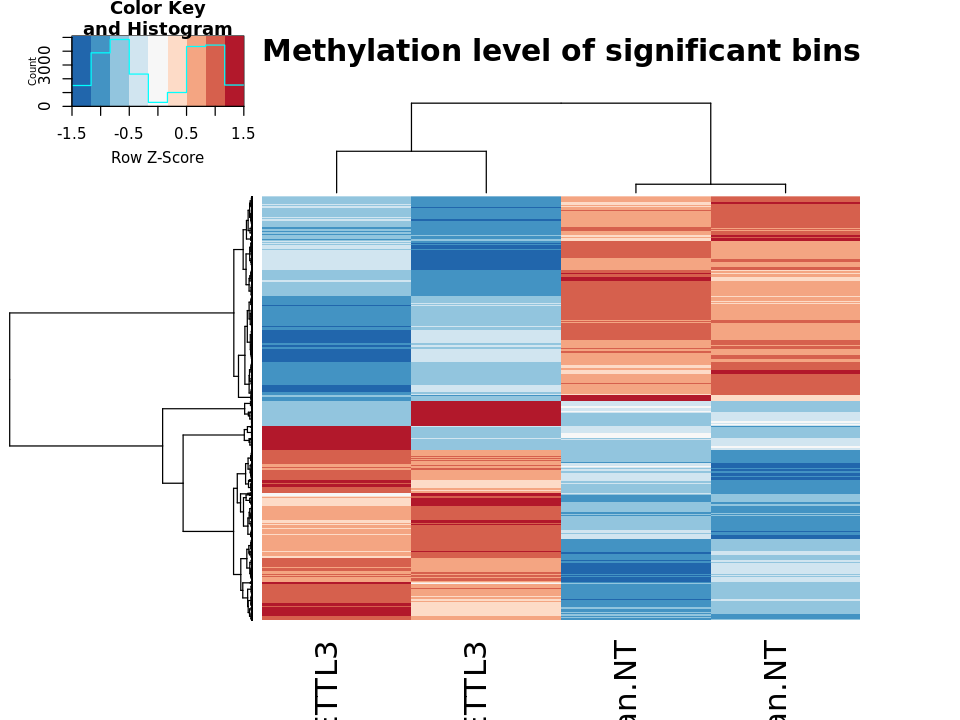

In [95]:
options(repr.plot.width=8, repr.plot.height=6)
plotHeatMap(radar)
# plotHeatMap(radar,covariates = FALSE)

There are 5737 reported differential loci at FDR < 0.1 and logFoldChange > 0.5.


Import genomic features from the file as a GRanges object ... OK
Prepare the 'metadata' data frame ... OK
Make the TxDb object ... Warning message in .get_cds_IDX(mcols0$type, mcols0$phase):
“The "phase" metadata column contains non-NA values for features of type
  stop_codon. This information was ignored.”OK


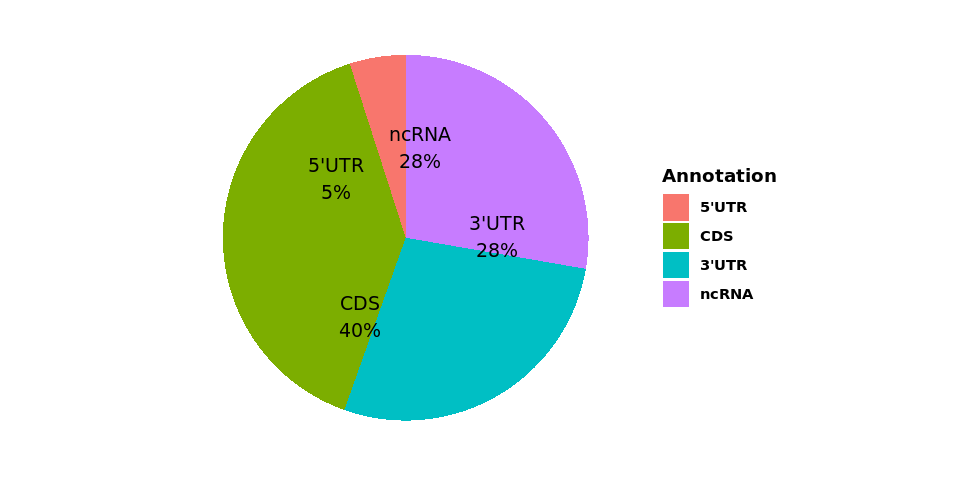

In [96]:
options(repr.plot.width=8, repr.plot.height=4)
peakDistribution(radar)

### Virma

In [97]:
radar = readRDS('radar/human/Virma/radar.rds')

Plot heat map for differential loci at FDR < 0.1 and logFoldChange > 0.5.
Returning normalized and expression level adjusted IP read counts.


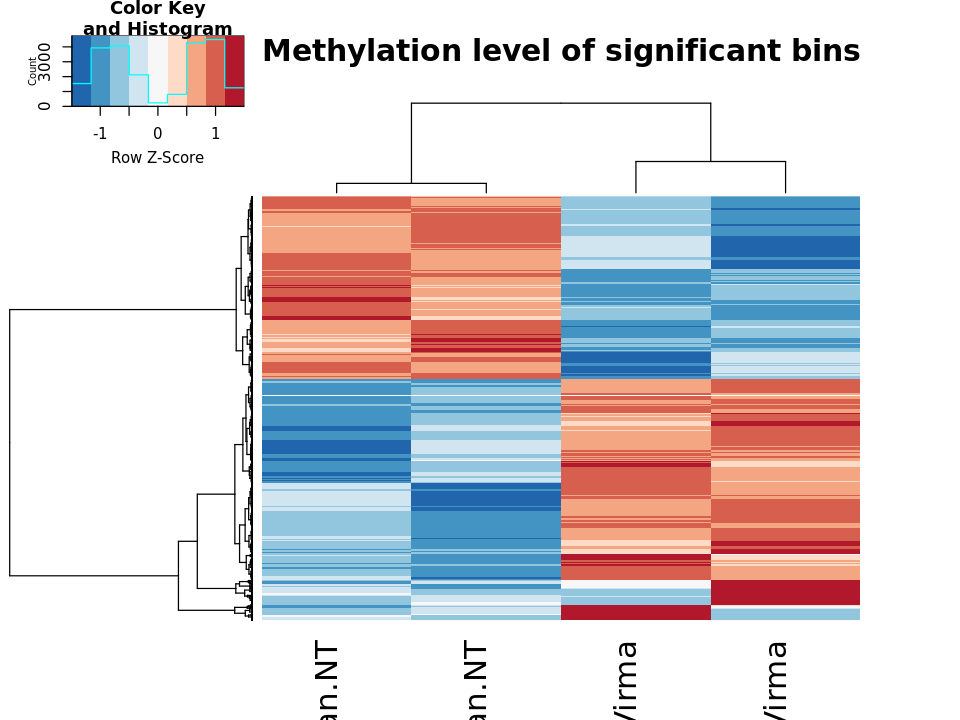

In [98]:
options(repr.plot.width=8, repr.plot.height=6)
plotHeatMap(radar)
# plotHeatMap(radar,covariates = FALSE)

There are 5488 reported differential loci at FDR < 0.1 and logFoldChange > 0.5.


Import genomic features from the file as a GRanges object ... OK
Prepare the 'metadata' data frame ... OK
Make the TxDb object ... Warning message in .get_cds_IDX(mcols0$type, mcols0$phase):
“The "phase" metadata column contains non-NA values for features of type
  stop_codon. This information was ignored.”OK


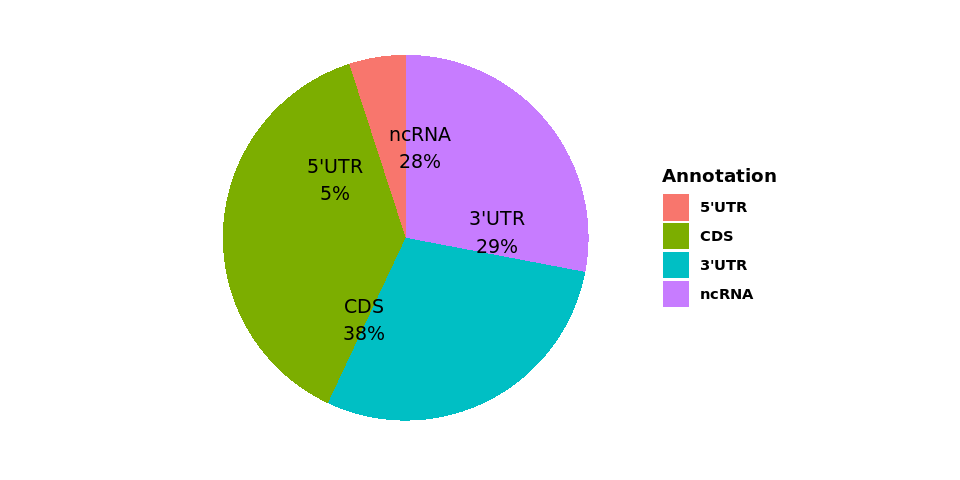

In [99]:
options(repr.plot.width=8, repr.plot.height=4)
peakDistribution(radar)

### WTAP

In [100]:
radar = readRDS('radar/human/WTAP/radar.rds')

Plot heat map for differential loci at FDR < 0.1 and logFoldChange > 0.5.
Returning normalized and expression level adjusted IP read counts.


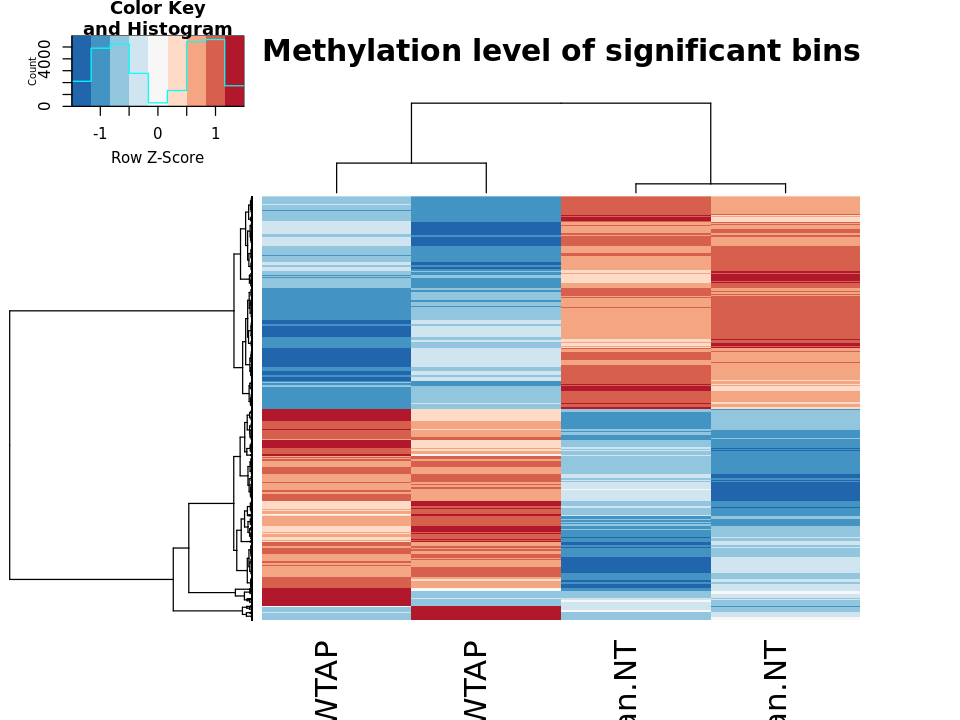

In [101]:
options(repr.plot.width=8, repr.plot.height=6)
plotHeatMap(radar)
# plotHeatMap(radar,covariates = FALSE)

There are 6961 reported differential loci at FDR < 0.1 and logFoldChange > 0.5.


Import genomic features from the file as a GRanges object ... OK
Prepare the 'metadata' data frame ... OK
Make the TxDb object ... Warning message in .get_cds_IDX(mcols0$type, mcols0$phase):
“The "phase" metadata column contains non-NA values for features of type
  stop_codon. This information was ignored.”OK


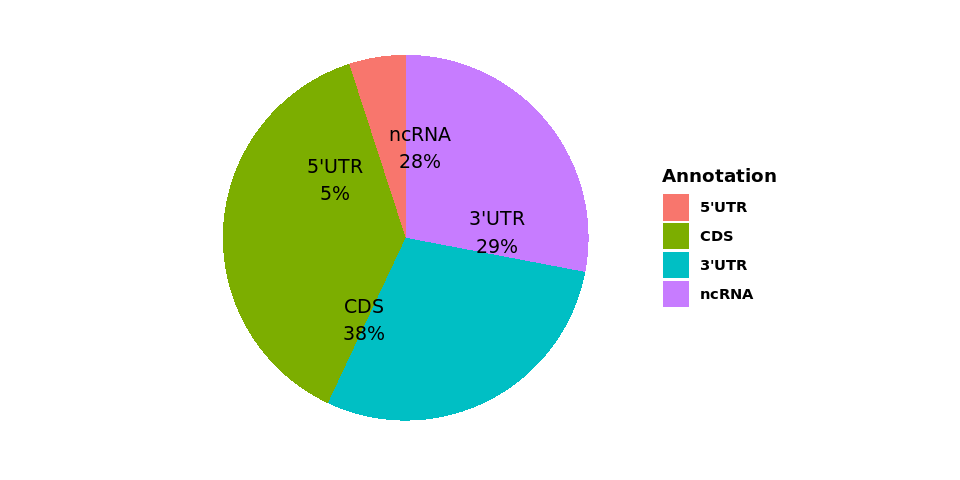

In [102]:
options(repr.plot.width=8, repr.plot.height=4)
peakDistribution(radar)

# Control

Comparing to RADAR package, exomepeak also claculate coverage for only non threted samples. We used different conda `environment` for exomepeak (and it takes long time to run!!). 

In [ ]:
library(exomePeak)
txdb <- makeTxDbFromGFF('/rumi/shams/genomes/hg38/gencode.v28.annotation.gtf',organism='Homo sapiens')
setwd("/rumi/shams/abe/People/Judd/bam")
print (txdb)
res <- exomepeak(
    TXDB=txdb,
    IP_BAM=list.files(pattern='human.NT.input.bam$'),
    INPUT_BAM=list.files(pattern='human.NT.m6A.bam$'),
    OUTPUT_DIR='../exomepeak/human',
    EXPERIMENT_NAME='control'
)
saveRDS(res, paste('../exomepeak','human','control', 'results.rds', sep='/'))

# Plot _Guitar_ 
Now, let's draw metagene plots for control samples:

In [5]:
library(Guitar)

In [6]:
txdb <- makeTxDbFromGFF('/rumi/shams/genomes/hg38/gencode.v28.annotation.gtf',organism='Homo sapiens')

Import genomic features from the file as a GRanges object ... OK
Prepare the 'metadata' data frame ... OK
Make the TxDb object ... Warning message in .get_cds_IDX(mcols0$type, mcols0$phase):
“The "phase" metadata column contains non-NA values for features of type
  stop_codon. This information was ignored.”OK


In [22]:
GuitarPlot(txTxdb = txdb,stBedFiles = list("exomepeak/human/control/peak.bed"),miscOutFilePrefix = "control")

[1] "20200219022907"
[1] "There are 203835 transcripts of 58381 genes in the genome."
[1] "total 203835 transcripts extracted ..."
[1] "total 94682 transcripts left after ambiguity filter ..."
[1] "total 94682 transcripts left after check chromosome validity ..."
[1] "total 11625 mRNAs left after component length filter ..."
[1] "total 56222 ncRNAs left after ncRNA length filter ..."
[1] "generate components for all tx"
[1] "generate components for mRNA"
[1] "generate components for lncRNA"
[1] "generate chiped transcriptome"
[1] "generate coverage checking ranges for tx"
[1] "generate coverage checking ranges for mrna"
[1] "generate coverage checking ranges for ncrna"
[1] "20200219023355"
[1] "import BED file exomepeak/human/control/peak.bed"
[1] "sample 10 points for Group1"


Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 18 out-of-bound ranges located on sequences
  ENST00000462394.1, ENST00000451518.1, ENST00000417185.6,
  ENST00000461612.1, ENST00000468175.1, ENST00000531163.5,
  ENST00000477790.1, ENST00000468964.1, ENST00000530673.1,
  ENST00000551665.1, ENST00000468017.1, ENST00000553460.5,
  ENST00000561962.1, ENST00000602562.1, ENST00000585471.1,
  ENST00000586991.1, ENST00000591969.1, and ENST00000595098.1. Note that
  ranges located on a sequence whose length is unknown (NA) or on a
  circular sequence are not considered out-of-bound (use seqlengths() and
  isCircular() to get the lengths and circularity flags of the underlying
  sequences). You can use trim() to trim these ranges. See
  ?`trim,GenomicRanges-method` for more information.”Warning message in valid.GenomicRanges.seqinfo(x, suggest.trim = TRUE):
“GRanges object contains 11 out-of-bound ranges located on sequences
  ENST00000479196.1, E

[1] "start figure plotting for tx ..."
[1] "start figure plotting for mrna ..."
[1] "start figure plotting for ncrna ..."


(activate python kernel)

In [1]:
from wand.image import Image as WImage

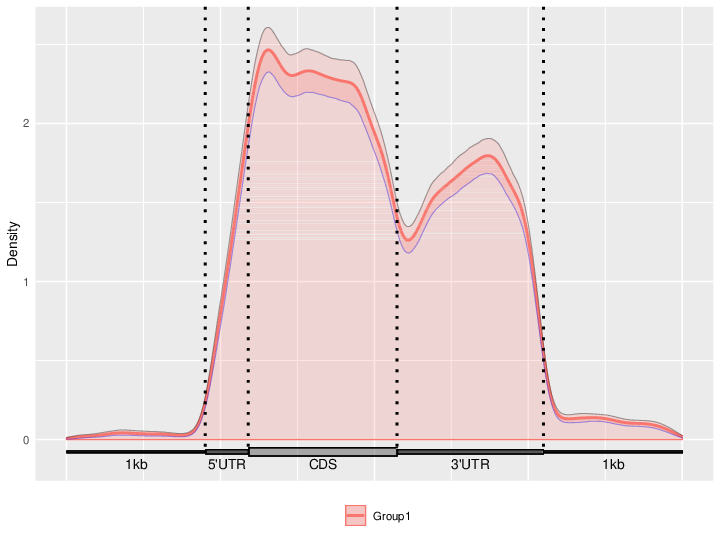

In [2]:
img = WImage(filename='control_mrna_test.pdf', resolution=90) # bigger
img

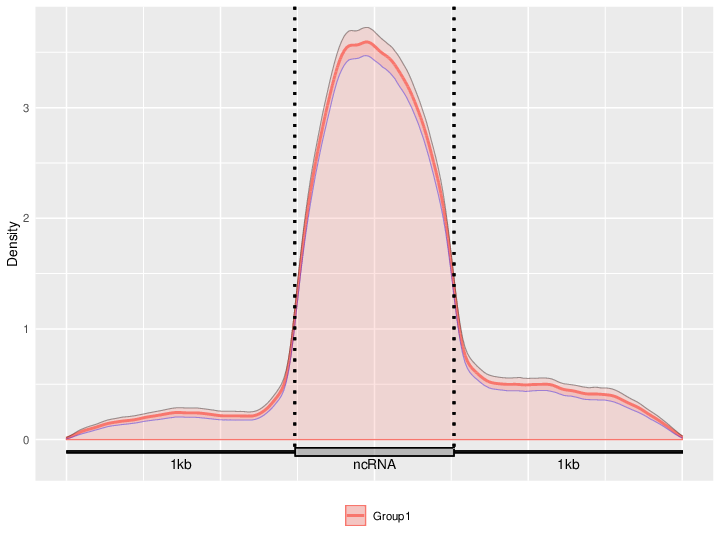

In [3]:
img = WImage(filename='control_ncrna_test.pdf', resolution=90) # bigger
img

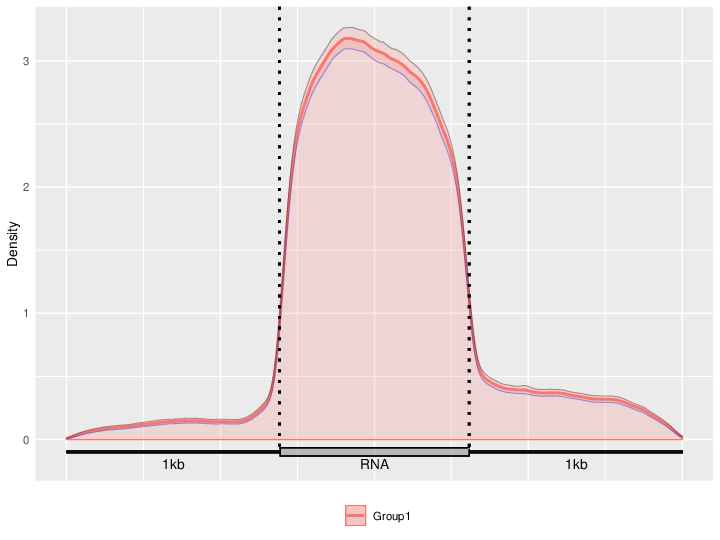

In [4]:
img = WImage(filename='control_tx_test.pdf', resolution=90) # bigger
img

## Motif analysis 

In [ ]:
%%bash 
cd exomepeak/human/control/

In [ ]:
%%bash 
bedtools getfasta -name -s -fi /rumi/shams/genomes/hg38/hg38.fa -bed peak.bed -split -fo peak.fa

In [ ]:
%%bash 
perl /flash/hani/bin/Tools/prep_seqs_for_teiser_run.pl peak.fa peaks

In [ ]:
%%bash 
perl $FIREDIR/fire.pl --expfile=peaks_teiser.txt --exptype=discrete --fastafile_rna=peaks_teiser.fa --nodups=1 --dodna=0 --dodnarna=0 --species=human --doskipdiscovery=1 --motiffile_rna=motifs_of_interest.txt --oribiasonly=0

In [ ]:
%%bash 
mv peaks_teiser.txt_FIRE/ motifs_of_interest_FIRE

`motifs_of_interest.txt` contains:
- `[AG]GAC`
- `[AGT][AG]AC[ACT]`


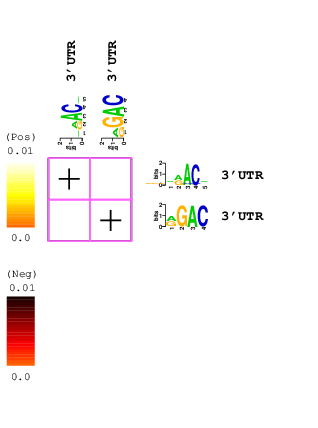

In [16]:
img = WImage(filename='exomepeak/human/control/motifs_of_interest_FIRE/RNA/peaks_teiser.txt.fullmimatrix.pdf', 
             resolution=100) # bigger
img

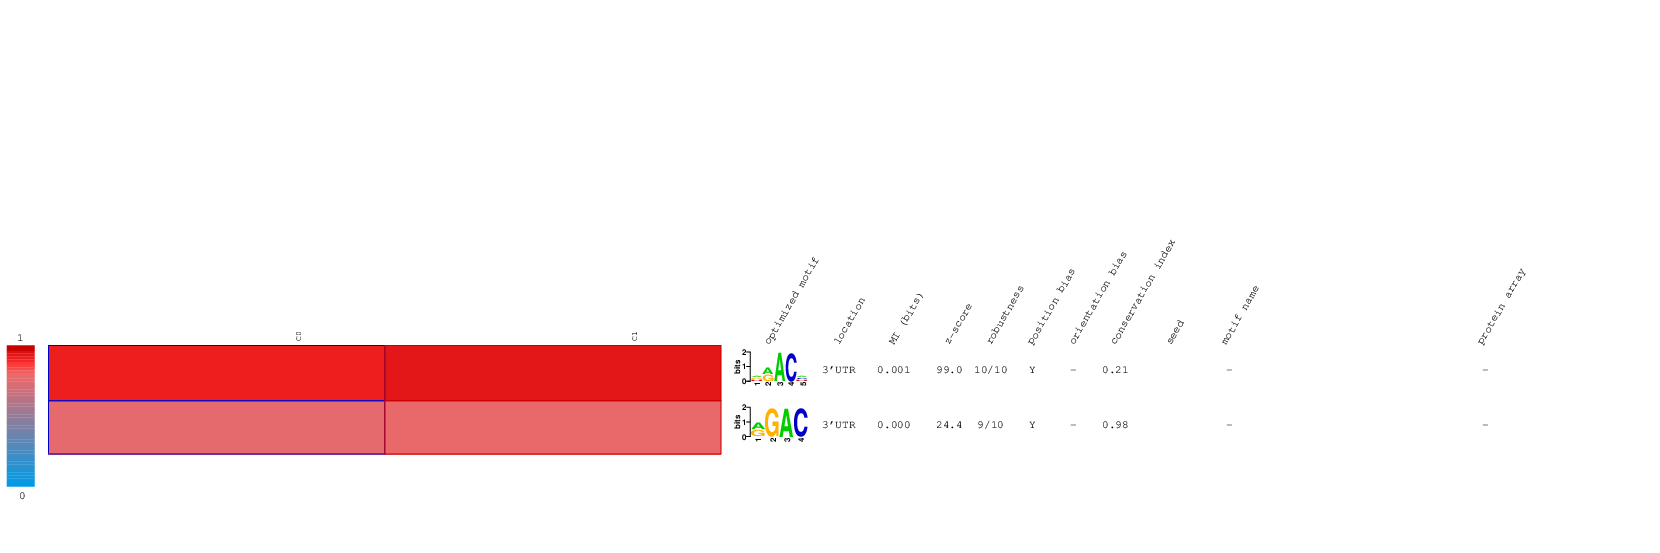

In [15]:
img = WImage(filename='exomepeak/human/control/motifs_of_interest_FIRE/RNA/peaks_teiser.txt.densities.pdf', 
             resolution=100) # bigger
img

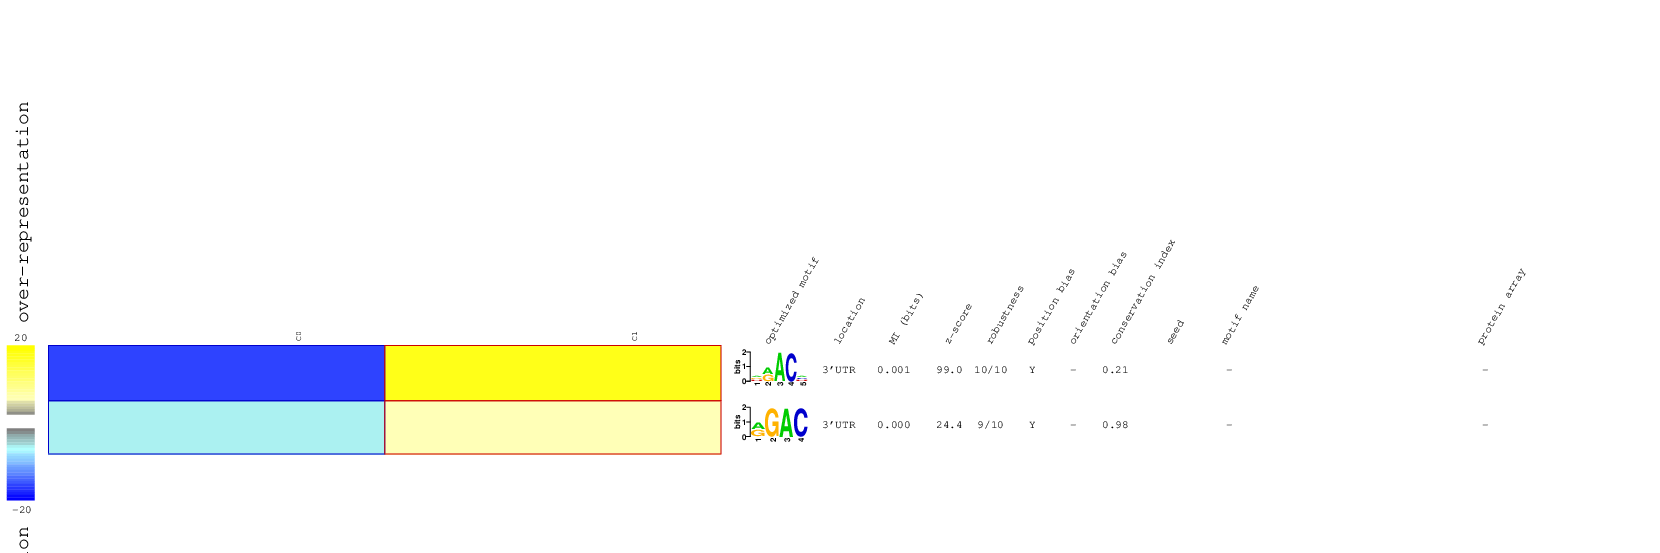

In [17]:
img = WImage(filename='exomepeak/human/control/motifs_of_interest_FIRE/RNA/peaks_teiser.txt.summary.pdf', 
             resolution=100) # bigger
img

In [ ]:
%%bash 
perl $FIREDIR/fire.pl --expfile=peaks_teiser.txt --exptype=discrete --fastafile_rna=peaks_teiser.fa --nodups=1 --dodna=0 --dodnarna=0 --species=human --oribiasonly=0

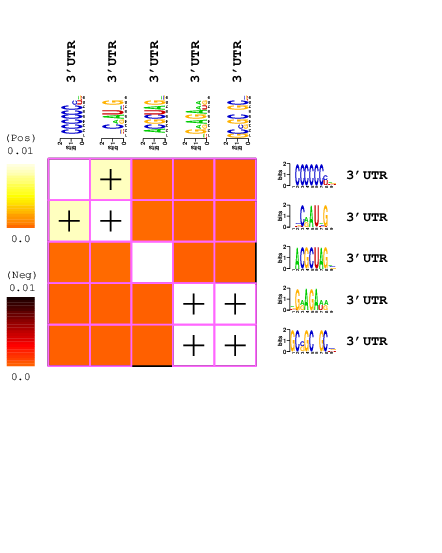

In [18]:
img = WImage(filename='exomepeak/human/control/peaks_teiser.txt_FIRE/RNA/peaks_teiser.txt.fullmimatrix.pdf', 
             resolution=100) # bigger
img

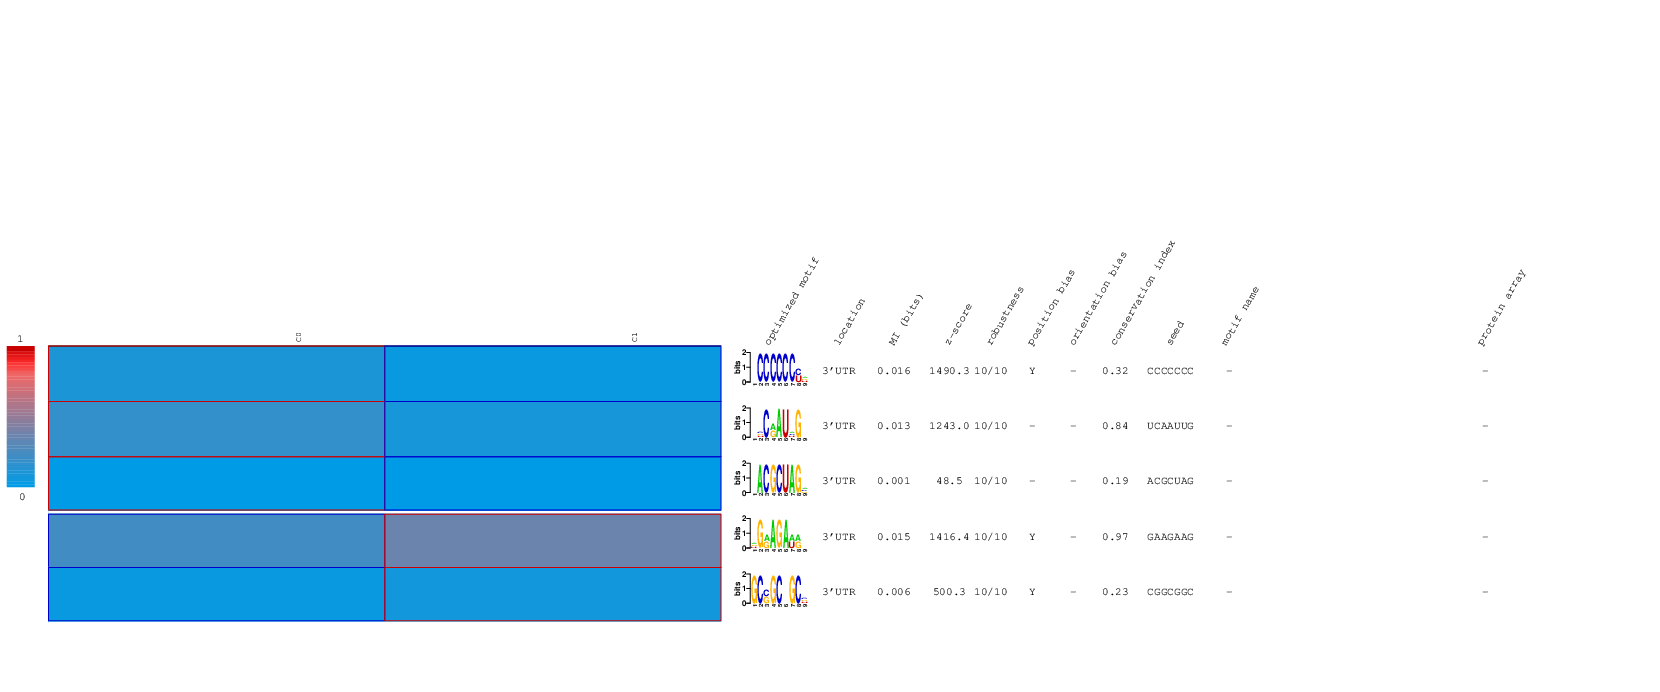

In [19]:
img = WImage(filename='exomepeak/human/control/peaks_teiser.txt_FIRE/RNA/peaks_teiser.txt.densities.pdf', 
             resolution=100) # bigger
img

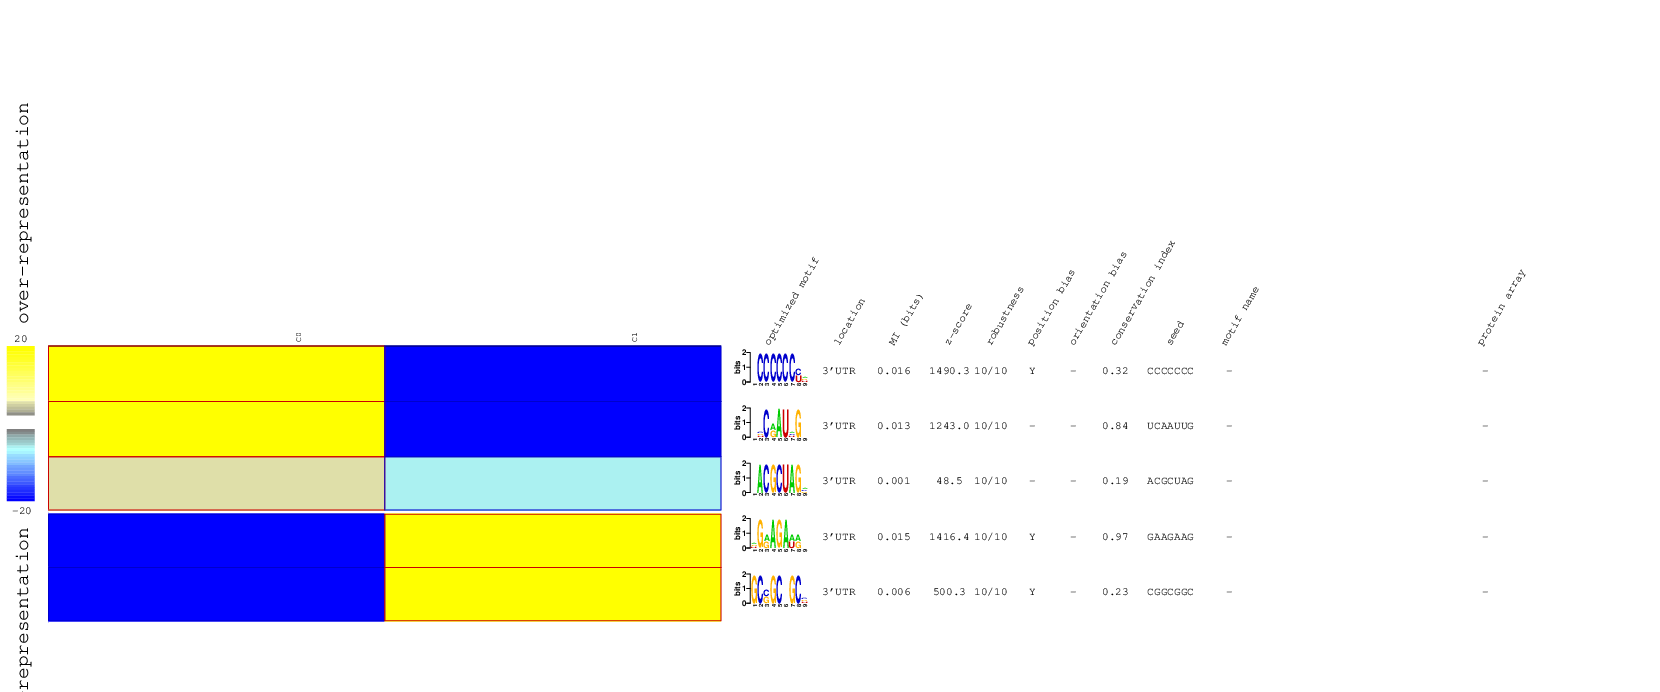

In [20]:
img = WImage(filename='exomepeak/human/control/peaks_teiser.txt_FIRE/RNA/peaks_teiser.txt.summary.pdf', 
             resolution=100) # bigger
img

In [ ]:
# ###############################  .bed to .fa ######################################### #
# use bioconda ucsc-twobittofa
# conda activate bedtools
# # remove duplicates from bed file
# grep -v '#' peak.bed | awk 'BEGIN{OFS="\t"}{print $1,$2,$3,$4,"1",$6}' > peak.c.bed
# twoBitToFa -noMask -bed=peak.drop_dup.bed /rumi/shams/genomes/hg38/hg38.2bit peak.fa

# run piranha for HIV bam files 

In [ ]:
%%bash
### m6A bam files ###
# Merge .bam files:
samtools merge -@ 12 piranha/hiv.m6A.bam bam/*hiv*m6A.bam
# sort the merged file >>> it's not making any change
samtools sort -@12 piranha/hiv.m6A.bam > piranha/hiv.m6A.srt.bam
# bam to bet
bedtools bamtobed -i piranha/hiv.m6A.srt.bam > piranha/hiv.m6A.srt.bed

### input bam files ###
# Merge .bam files:
samtools merge -@ 12 piranha/hiv.input.bam bam/*hiv*input.bam
# sort the merged file >>> it's not making any change
samtools sort -@12 piranha/hiv.input.bam > piranha/hiv.input.srt.bam
# bam to bet
bedtools bamtobed -i piranha/hiv.input.srt.bam > piranha/hiv.input.srt.bed

### run Piranha ###
Piranha -s -i 50 piranha/hiv.m6A.srt.bed piranha/hiv.input.srt.bed -o piranha/hiv.piranha.txt
# make new ref file
awk '{printf("%s\t%d\t%d\t%d\t1\t%s\n",$1,$2,$3, NR,$4)}' piranha/hiv.piranha.txt > piranha/final_piranha.bed
awk '{printf("%s\t%s\t%d\t%d\t%s\n",$4,$1,$2+1,$3,$6)}' piranha/final_piranha.bed > piranha/final_piranha.saf
### first line of piranha/final_piranha.saf removed 

In [ ]:
%%bash
# make new reletive counts
for f in bam/*hiv*.m6A.bam; do
    out=${f/.bam/.piranha.fc};
    out=${out/bam/piranha\/fc};
    echo featureCounts -T 12 -O -F SAF -a piranha/final_piranha.saf -o $out $f;
done

for f in bam/*hiv*.input.bam; do
    out=${f/.bam/.piranha.fc};
    out=${out/bam/piranha\/fc};
    echo featureCounts -T 12 -O -F SAF -a piranha/final_piranha.saf -o $out $f;
done

(activate R kernel)

In [7]:
library(DESeq2)
library(ggplot2)
library(tidyverse)

In [3]:
files <- list.files(path = "piranha/fc", pattern="fc$") 
reps <- c(rep('s23',10),rep('s24',10))
ip <- rep(c('input','m6A'),10)
enzymes <- rep(unlist(lapply(c('METTL14','METTL3','NT','Virma','WTAP'), rep, 2)),2)
conds <- ip
all_conds <- paste(
    reps,
    enzymes, 
    ip, 
    sep='.')
datalist <- lapply(files, function(x){read.table(file=paste('piranha/fc/', x, sep = "") ,header=TRUE,colClasses=c(NA, "NULL", "NULL", "NULL", "NULL", "NULL", NA),check.names=F)})
m <- Reduce(function(...) merge(..., by=1, all = TRUE), datalist)
rownames(m) <- paste ('hiv',m[,1],sep='-')
m <- m[,-1]
m[is.na(m)]<-0
m <- round(m)
colnames(m) <- all_conds
colData <- data.frame(cond = conds, row.names=colnames(m))

In [4]:
# dds <- DESeqDataSetFromMatrix(countData = m, colData = colData, design = ~ cond)
# dds$cond <- relevel(dds$cond, ref="input")
# dds <- DESeq(dds)
# cds <- estimateDispersions(dds)
# vsd <- varianceStabilizingTransformation(cds)
# # PCA Plot 
# z <- plotPCA(vsd,intgroup=c("cond"), returnData=TRUE)
# percentVar <- round(100 * attr(z, "percentVar"))
# p <- ggplot(z, aes(PC1, PC2)) +
#   geom_point() +
#   geom_text(aes(label=name),hjust=0, vjust=0) + 
#   xlab(paste0("PC1: ",percentVar[1],"% variance")) +
#   ylab(paste0("PC2: ",percentVar[2],"% variance")) +
# #   geom_label_repel(label = cond, force = 10) +
#     guides(size = FALSE)
# # ggsave(paste('results/plots/model_',i,'_Volcano.pdf',sep=''), plot = vol, device = 'pdf')
# print (p)

comparing m6A/input for each knockdown to control


In [5]:
for (enz in c('METTL14','METTL3','Virma','WTAP')){
    icond = c(grep(enz,all_conds), grep('NT',all_conds) )
    mm <- m[,icond]
    colData <- data.frame(cond= conds[icond], row.names=colnames(mm))
    dds <- DESeqDataSetFromMatrix(countData = mm, colData = colData, design = ~ cond)
    dds$cond <- relevel(dds$cond, ref='input')
    dds <- DESeq(dds)
    cds <- estimateDispersions(dds)
    vsd <- varianceStabilizingTransformation(cds)
    # normalized counts 
    ncu <- counts(dds, normalized=TRUE)
    # Raw tabels 
    write.table(ncu, file=paste("piranha/results/",enz,".hiv.","gene_count_table_DE2norm.txt", sep=''), sep="\t", quote=FALSE, col.names=colnames(mm)) 
    write.table(mm, file=paste("piranha/results/",enz,".hiv.","gene_count_table_raw.txt", sep=''), sep="\t", quote=FALSE, col.names=colnames(mm))
    # model:
    res <- results(dds)
    write.table(res, paste("piranha/results/",enz,".hiv.","input_vs_m6A.txt", sep='.'), sep="\t", quote=FALSE, col.names=NA)
    ## Volcano plot 
    print(enz)
    print(data.frame(res))
#     vol = data.frame(res) %>% ggplot(aes(x=log2FoldChange, y=-log10(pvalue))) + 
#             geom_point(alpha = 6/10) + 
#             xlim(c(-5,5)) + 
#             ylim(c(0,20)) + 
#             theme_bw() + 
#             theme(legend.position="none")
#     ggsave(paste('results/plots/model_',i,'_Volcano.pdf',sep=''), plot = vol, device = 'pdf')
#     print (vol)
}

converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
found already estimated dispersions, replacing these
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.
Warning message in lfproc(x, y, weights = weights, cens = cens, base = base, geth = geth, :
“Estimated rdf < 1.0; not estimating variance”

[1] "METTL14"
        baseMean log2FoldChange      lfcSE       stat       pvalue         padj
hiv-1   752.0882      0.2532777 0.12795013   1.979503 4.775941e-02 4.775941e-02
hiv-2  5986.0923     -0.8643467 0.07039247 -12.278965 1.174913e-34 2.349825e-34
hiv-3 11807.5413      1.3244821 0.07376851  17.954574 4.419615e-72 1.325885e-71
hiv-4  6485.3134     -0.1764200 0.08455448  -2.086465 3.693652e-02 4.432383e-02
hiv-5  5592.9043     -1.6038991 0.07622029 -21.042941 2.653975e-98 1.592385e-97
hiv-6  3089.2212      0.5042731 0.09793016   5.149313 2.614420e-07 3.921629e-07


converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.
Warning message in lfproc(x, y, weights = weights, cens = cens, base = base, geth = geth, :
“Estimated rdf < 1.0; not estimating variance”final dispersion estimates
fitting model and testing
found already estimated dispersions, replacing these
gene-wise dispersion estimates
mean-dispersion relationship
-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.
Warning message in lfproc(x, y, weights = weights, cens = cens, base = base, 

[1] "METTL3"
        baseMean log2FoldChange      lfcSE       stat       pvalue         padj
hiv-1   741.0372      0.2078463 0.08045898   2.583259 9.787193e-03 9.787193e-03
hiv-2  6296.5833     -0.6824027 0.17938734  -3.804074 1.423355e-04 2.846710e-04
hiv-3 11634.7868      1.3223801 0.08282794  15.965387 2.226562e-57 1.335937e-56
hiv-4  6128.1744     -0.2175230 0.06409406  -3.393809 6.892769e-04 8.271323e-04
hiv-5  5605.1813     -1.6395908 0.14862574 -11.031674 2.688132e-28 8.064396e-28
hiv-6  3021.7458      0.4626494 0.12751418   3.628219 2.853829e-04 4.280743e-04


converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
found already estimated dispersions, replacing these
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.
Warning message in lfproc(x, y, weights = weights, cens = cens, base = base, geth = geth, :
“Estimated rdf < 1.0; not estimating variance”

[1] "Virma"
        baseMean log2FoldChange      lfcSE       stat       pvalue         padj
hiv-1   767.3069      0.2099538 0.09420393   2.228716 2.583282e-02 2.583282e-02
hiv-2  6075.9420     -0.8983206 0.07315040 -12.280461 1.153386e-34 2.306771e-34
hiv-3 11876.7118      1.3206351 0.08059207  16.386662 2.381673e-60 7.145020e-60
hiv-4  6349.0233     -0.1902048 0.07931707  -2.398031 1.648349e-02 1.978019e-02
hiv-5  5639.5067     -1.5902197 0.09156194 -17.367693 1.449367e-67 8.696203e-67
hiv-6  3052.0495      0.4507251 0.08131744   5.542785 2.976975e-08 4.465462e-08


converting counts to integer mode
estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.
final dispersion estimates
fitting model and testing
found already estimated dispersions, replacing these
gene-wise dispersion estimates
mean-dispersion relationship
-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.
final dispersion estimates
-- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType=

[1] "WTAP"
        baseMean log2FoldChange     lfcSE       stat       pvalue         padj
hiv-1   690.3316      0.1498298 0.1285014  1.1659773 2.436236e-01 2.923483e-01
hiv-2  6376.0361     -0.5887514 0.2006921 -2.9336047 3.350506e-03 5.025760e-03
hiv-3 12179.6886      1.4398561 0.1330853 10.8190443 2.796784e-27 1.678070e-26
hiv-4  6413.6543     -0.1027711 0.1821795 -0.5641199 5.726725e-01 5.726725e-01
hiv-5  5609.1909     -1.5799500 0.1965073 -8.0401576 8.972300e-16 2.691690e-15
hiv-6  2908.0368      0.4729421 0.1389686  3.4032307 6.659403e-04 1.331881e-03


In [8]:
sessionInfo()

R version 3.6.2 (2019-12-12)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: Ubuntu 18.04.2 LTS

Matrix products: default
BLAS/LAPACK: /rumi/shams/abe/anaconda3/envs/RADAR/lib/libopenblasp-r0.3.7.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    parallel  stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] forcats_0.4.0               stringr_1.4.0              
 [3] purrr_0.3.3                 readr_1.3.1                
 [5] tidyr_0.8.3                 tibble_2.1.3               
 [7] tidyverse_1.2.1             DESeq2_1.26.0              
 [9] SummarizedExperiment_1.16.